In [1]:
%%capture
!pip install kats

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tsfeature as tsf
import sys
sys.path.append("../")

import pprint
from sklearn.decomposition import PCA
from kats.consts import TimeSeriesData
from statsmodels.tsa.seasonal import STL
from kats.utils.simulator import Simulator
from sklearn.preprocessing import StandardScaler
from kats.tsfeatures.tsfeatures import TsFeatures

import warnings
warnings.simplefilter(action='ignore')

C:\ProgramData\Anaconda3\envs\kats\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Ver con glob para carpeta local
df= pd.read_csv('notificaciones_clima_7_dias_COMBINADO_SEMANAL.csv', sep=';')
poblacion= pd.read_csv('Poblacion_Paraguay.csv', sep=',')

In [4]:
poblacion['#'] = poblacion['#'].str.upper()
poblacion = poblacion.head(268)
poblacion.rename(columns = {'#':'Ciudad'}, inplace = True)

In [5]:
poblacion['Ciudad'].iloc[1] == df['distrito_notif'].iloc[0]

True

In [6]:
print("La cantidad de ciudades con casos es:", df['distrito_notif'].nunique())
print("La cantidad de ciudades con datos de población:", poblacion['Ciudad'].nunique())

La cantidad de ciudades con casos es: 238
La cantidad de ciudades con datos de población: 266


In [7]:
S1 = set(list(dict.fromkeys(df['distrito_notif'].tolist())))
S2 = set(list(dict.fromkeys(poblacion['Ciudad'].tolist())))
ciudades = S1.intersection(S2)
ciudades = list(ciudades)
ciudades

['UNION',
 'ARROYOS Y ESTEROS',
 'PARAGUARI',
 'CARAYAO',
 'NUEVA ALBORADA',
 'PIRAPO',
 'HOHENAU',
 'LA PALOMA',
 'ALTO VERA',
 'NUEVA ESPERANZA',
 'DR. JUAN MANUEL FRUTOS',
 'SAN JUAN DEL PARANA',
 'FUERTE OLIMPO',
 'MINGA GUAZU',
 'MCAL. ESTIGARRIBIA',
 'MCAL. FRANCISCO SOLANO LOPEZ',
 'ITAPUA POTY',
 'SIMON BOLIVAR',
 'COLONIA INDEPENDENCIA',
 'MBOCAYATY DEL YHAGUY',
 'LOMA PLATA',
 'CAPITAN MIRANDA',
 'LOMA GRANDE',
 'YATAITY',
 'SAN COSME Y DAMIAN',
 'BUENA VISTA',
 'VILLA ELISA',
 'SANTA MARIA',
 'JESUS',
 'JOSE DOMINGO OCAMPOS',
 'SAPUCAI',
 'ISLA UMBU',
 'SAN MIGUEL',
 '25 DE DICIEMBRE',
 'DESMOCHADOS',
 'ASUNCION',
 'NATALIO',
 'NUEVA LONDRES',
 'AYOLAS',
 'SAN ALBERTO',
 'CAPITAN MEZA',
 'SANTA ROSA DEL AGUARAY',
 'PASO YOBAI',
 'NARANJAL',
 'NUEVA ITALIA',
 'GENERAL ARTIGAS',
 'YAGUARON',
 'ATYRA',
 'BAHIA NEGRA',
 'BELLA VISTA',
 'EUSEBIO AYALA',
 'CONCEPCION',
 'NUEVA GERMANIA',
 'SALTO DEL GUAIRA',
 'ENCARNACION',
 'CAAZAPA',
 'PIRAYU',
 'MARIANO ROQUE ALONSO',
 'TRINIDA

In [8]:
df = df[['anio','distrito_notif', 'semana', 'casos']]
df.rename(columns = {'anio':'Año', 'distrito_notif':'Distrito'}, inplace = True)

In [9]:
df

,Año,Distrito,semana,casos
0,2009,ASUNCION,2,2
1,2009,FERNANDO DE LA MORA,2,1
2,2009,PEDRO JUAN CABALLERO,2,2
3,2009,YBY YAU,2,4
4,2009,YPANE,2,1
...,...,...,...,...
8482,2013,VILLA HAYES,52,6
8483,2013,VILLETA,52,3
8484,2013,YAGUARON,52,1
8485,2013,YPACARAI,52,2


In [10]:
df = df[df['Distrito'].isin(ciudades)]
listaDistrito = df['Distrito'].tolist()
listaDistrito = list(dict.fromkeys(listaDistrito))
#print(listaDistrito)
pob = []
for year in list(range(2009,2014)):
    aux = df[df['Año'] == year]
    for dis in aux.Distrito.values:
        pob.append(int(poblacion[poblacion.Ciudad == dis][str(year)].values[0]))   
print(len(pob))

6921


In [11]:
df['Poblacion'] = pob

In [12]:
df['incidencia'] = (df.casos/df.Poblacion)*100000
df

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2009,ASUNCION,2,2,531388,0.376373
1,2009,FERNANDO DE LA MORA,2,1,143116,0.698734
2,2009,PEDRO JUAN CABALLERO,2,2,103243,1.937177
4,2009,YPANE,2,1,36547,2.736203
5,2009,ASUNCION,3,1,531388,0.188186
...,...,...,...,...,...,...
8482,2013,VILLA HAYES,52,6,46033,13.034128
8483,2013,VILLETA,52,3,33890,8.852169
8484,2013,YAGUARON,52,1,30369,3.292832
8485,2013,YPACARAI,52,2,25002,7.999360


In [13]:
df = df[(df['Año'] == 2012) | (df['Año'] == 2013)]
df.reset_index(drop=True)

,Año,Distrito,semana,casos,Poblacion,incidencia
0,2012,CAACUPE,1,1,51275,1.950268
1,2012,CAPIATA,1,7,206686,3.386780
2,2012,CONCEPCION,1,4,76819,5.207045
3,2012,FERNANDO DE LA MORA,1,12,153449,7.820188
4,2012,HORQUETA,1,27,57411,47.029315
...,...,...,...,...,...,...
3983,2013,VILLA HAYES,52,6,46033,13.034128
3984,2013,VILLETA,52,3,33890,8.852169
3985,2013,YAGUARON,52,1,30369,3.292832
3986,2013,YPACARAI,52,2,25002,7.999360


In [14]:
def run_length_encoding(x):
    """
    :param x: np.array
    :return: np.array
    """
    pos, = np.where(np.diff(x) != 0)
    pos = np.concatenate(([0], pos+1, [len(x)]))
    # rle = [(a,b,x[a]) for (a,b) in zip(pos[:-1],pos[1:])]
    rle = [b - a for (a, b) in zip(pos[:-1], pos[1:])]
    return rle


def hysteresis(x, th_lo, th_hi, initial=False):
    """
    :param x: np.array
    :param th_lo: float
    :param th_hi: float
    :param initial: ???
    :return:
    """
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    # prevent index error if ind is empty
    if not ind.size:
        return np.zeros_like(x, dtype=bool) | initial
    # from 0 to len(x)
    cnt = np.cumsum(lo_or_hi)
    return np.where(cnt, hi[ind[cnt-1]], initial)


def arg_longest_not_null(x):
    # pad with np.nan while finding where null
    m = np.concatenate(( [True], np.isnan(x), [True] ))
    # Start-stop limits
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
    # Get max interval, interval limits
    start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]
    return start, stop

In [15]:
class poly(object):
    """ Orthogonal polynomials

    Source:
        http://davmre.github.io/python/2013/12/15/orthogonal_poly
    """

    def __init__(self):
        self.degree = None
        self.z = None
        self.norm2 = None
        self.alpha = None

    def fit(self, x, degree=1):

        self.degree = degree

        n = degree + 1
        x = np.asarray(x).flatten()
        if degree >= len(np.unique(x)):
            raise ValueError("'degree' must be less than number of unique points")

        xbar = np.mean(x)
        x = x - xbar
        q, r = np.linalg.qr(np.fliplr(np.vander(x, n)))

        z = np.diag(np.diag(r))
        raw = np.dot(q, z)

        norm2 = np.sum(raw**2, axis=0)
        alpha = (np.sum((raw**2)*np.reshape(x, (-1, 1)), axis=0)/norm2 + xbar)[:degree]
        z = raw / np.sqrt(norm2)

        self.z = z
        self.norm2 = norm2
        self.alpha = alpha

    def predict(self, x):
        x = np.asarray(x).flatten()
        n = self.degree + 1
        z = np.empty((len(x), n))
        z[:, 0] = 1

        if self.degree > 0:
            z[:, 1] = x - self.alpha[0]

        if self.degree > 1:
            for i in np.arange(1, self.degree):
                z[:, i+1] = (x - self.alpha[i]) * z[:, i] - (self.norm2[i] / self.norm2[i-1]) * z[:, i-1]

        z /= np.sqrt(self.norm2)

        return z

# Fig Func

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as scale_data


def biplot_features(x, robust=False, scale=True,  col=None, **kwargs):
    X = x.dropna(axis=1, how='all').dropna(axis=0, how='any')

    if col is None:
        col = ("#000000", "darkred")
    else:
        col = [col] if not isinstance(col, (list, tuple)) else col
        col = np.unique(col)

        if len(col) == 1:
            col = np.repeat(col, 2)
        else:
            col = np.unique(col)[0:2]

    if scale:
        X = scale_data(X, with_mean=True, with_std=True)

    if robust:
        raise NotImplemented('Robust PCA has not been implemented yet')
    else:
        pca = PCA(n_components=2)
        pca.fit(X)
        proj_pca = pca.transform(X)

    plt.figure()
    plt.scatter(x=proj_pca[:, 0], y=proj_pca[:, 1], c=col)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

In [17]:
from numpy.lib.stride_tricks import sliding_window_view

In [18]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import boxcox_normmax
from statsmodels.sandbox.gam import AdditiveModel

try:
    from entropy import spectral_entropy
except ImportError:
    ENTROPY_PACKAGE_AVAILABLE = False
else:
    ENTROPY_PACKAGE_AVAILABLE = True

# features_hyndman
# https://github.com/robjhyndman/anomalous/blob/master/R/tsmeasures.R

_VARIABLE_COUNT = 0


def trim(x, trim=0.1):
    """Trimmed time series eliminating outliers's influence"""
    qtl = x.quantile([trim, 1 - trim])
    lo = qtl.iloc[0]
    hi = qtl.iloc[1]

    trim_x = x.copy()
    trim_x[(trim_x < lo) | (trim_x > hi)] = np.nan
    return trim_x


def first_order_autocorrelation(x):
    """First order of autocorrelation"""
    return x.autocorr(1)


def lumpiness(x, width):
    """Lumpiness

    Note:
        Cannot be used for yearly data
    """
    nr = len(x)
    start = np.arange(1, nr, step=width, dtype=int)
    end = np.arange(width, nr + width, step=width, dtype=int)

    nsegs = int(nr / width)

    varx = np.zeros(nsegs)

    for idx in range(nsegs):
        tmp = x[start[idx]:end[idx]]
        varx[idx] = tmp[~np.isnan(tmp)].var()

    lump = varx[~np.isnan(varx)].var()
    return lump


def rolling_level_shift(x, width):
    """Level shift

    Using rolling window
    """

    tmp = x.dropna()
    roll_mean = tmp.rolling(width).mean()

    try:
        level_shifts = roll_mean.diff(width).abs().max()
    except Exception:
        level_shifts = np.nan

    return level_shifts


def rolling_variance_change(x, width):
    """Variance change

    Using rolling window

    """
    tmp = x.dropna()

    roll_var = tmp.rolling(width).var()

    try:
        variance_change = roll_var.diff(width).abs().max()
    except Exception:
        variance_change = np.nan

    return variance_change


def n_crossing_points(x):
    """Number of crossing points"""
    mid_line = ((x.max() - x.min()) / 2.0)
    ab = (x <= mid_line).values
    len_x = len(x)
    p1 = ab[1:(len_x - 1)]
    p2 = ab[2:len_x]
    cross = (p1 & ~p2) | (p2 & ~p1)
    return cross.sum()


def flat_spots(x):
    """Flat spots using discretization"""

    try:
        cut_x = pd.cut(x, bins=10, include_lowest=True, labels=False)
        rle_x = run_length_encoding(cut_x)
        spots = max(rle_x)
    except Exception:
        spots = np.nan

    #  Any flat spot
    return spots


def trend_seasonality_spike_strength(x, freq):
    """Strength of trend and seasonality and spike"""
    cont_x = x.dropna()
    length_cont_x = len(cont_x)
    season = peak = trough = np.nan

    if length_cont_x < (2 * freq):
        trend = linearity = curvature = season = spike = peak = trough = np.nan
    else:

        if freq > 1:
            all_stl = sm.tsa.seasonal_decompose(cont_x, freq=freq)
            trend0 = all_stl.trend
            fits = trend0 + all_stl.seasonal
            adj_x = cont_x - fits
            v_adj = adj_x.var()
            detrend = cont_x - trend0
            deseason = cont_x - all_stl.seasonal
            peak = all_stl.seasonal.max()
            trough = all_stl.seasonal.min()
            remainder = all_stl.resid
            season = 0 if detrend.var() < 1e-10 else max(0, min(1, 1 - v_adj/detrend.var()))

        else:  # No seasonal component
            tt = np.array([range(length_cont_x)]).T

            _trend0_values = AdditiveModel(tt).fit(cont_x.values).mu
            trend0=pd.Series(_trend0_values, index=cont_x.index)
            remainder = cont_x - trend0
            deseason = cont_x - trend0
            v_adj = trend0.var()

        trend = 0 if deseason.var() < 1e-10 else max(0, min(1, 1 - v_adj/deseason.var()))

        n = len(remainder)
        v = remainder.var()
        d = (remainder - remainder.mean())**2
        varloo = (v * (n - 1) - d) / (n - 2)
        spike = varloo.var()
        pl = poly()
        pl.fit(range(length_cont_x), degree=2)
        result_pl = pl.predict(range(length_cont_x))  # [:, 2]

        X = sm.add_constant(result_pl, has_constant='add')
        ols_data = trend0.copy()
        ols_data = pd.concat([ols_data.reset_index(drop=True), pd.DataFrame(X)], axis=1, ignore_index=True)
        ols_data.columns = ['Y', 'Intercept', 'X1', 'X2', 'X3']
        result_ols = ols('Y ~ X1 + X2 + X3', data=ols_data.dropna())

        trend_coef = result_ols.fit().params
        linearity = trend_coef[1]
        curvature = trend_coef[2]

    result = dict(trend=trend, spike=spike, peak=peak, trough=trough, linearity=linearity, curvature=curvature)

    if freq > 1:
        result["season"] = season

    return result


def kullback_leibler_score(x, window, threshold=None):
    """Kullback-Leibler score"""

    if threshold is None:
        threshold = norm.pdf(38)

    gw = 100  # grid width
    xgrid = np.arange(x.min(), x.max(), step=(x.max() - x.min()) / gw, dtype=float)
    grid = xgrid[1] - xgrid[0]
    tmpx = x[~x.isnull()]  # Remove NA to calculate bw
    bw = gaussian_kde(tmpx).covariance_factor()
    len_x = len(x)

    if len_x <= (2 * window):
        raise ValueError("Cannot compute KLscore when the length is too small.")

    dens_mat = np.zeros((len_x, gw))

    for i in range(len_x):
        dens_mat[i, :] = norm.pdf(xgrid, x[i], bw)

    dens_mat = np.clip(dens_mat, threshold, None)
    #print(dens_mat.shape)
    #dens_mat = dens_mat.to_frame()
    rmean = sliding_window_view(dens_mat, window_shape = window, axis=1)#.mean()
    rmean = rmean.mean(axis=(2))
    #print(rmean.shape)
    lo = list(range(len_x - window + 1))
    hi = list(range(window + 1, len_x))
    seqidx = min(len(lo), len(hi))
    kl = np.zeros(seqidx)
    
    for i in range(seqidx):
        kl[i] = np.sum(rmean[lo[i], ] * (np.log(rmean[lo[i], ]) - np.log(rmean[hi[i], ])) * grid)
    diffkl = pd.Series(kl).dropna().diff()
    maxidx = np.argmax(diffkl)
    return dict(score=np.max(diffkl), change_idx=maxidx)


def boxcox_optimal_lambda(x):
    y = x + 0.0000001 if np.any(x == 0) else x
    return boxcox_normmax(y)


# TODO: implement Spectral Entropy
def entropy(x, freq=1, normalize=False):
    """
    Spectral Entropy
    """
    try:
        start, stop = arg_longest_not_null(x)
        result = spectral_entropy(x[start:stop], sf=freq, method='welch', normalize=normalize)
    except Exception:
        result = np.nan
    finally:
        return result


def ts_measures(x, freq=1, normalize=True, width=None, window=None):
    """
    See `ts_measures_series` doc
    """

    if isinstance(x, pd.Series):
        measures_df = ts_measures_series(x, freq=freq, normalize=normalize, width=width, window=window)
    elif isinstance(x, pd.DataFrame):
        _buffer = []
        for c in x.columns:
            _buffer.append(ts_measures_series(x[c], freq=freq, normalize=normalize, width=width, window=window))
        measures_df = pd.concat(_buffer, axis=0)

    elif issubclass(x.__class__, pd.core.groupby._GroupBy):
        _buffer = []
        for i in x.groups:
            _buffer.append(ts_measures(x.get_group(i), freq=freq, normalize=normalize, width=width, window=window))

        measures_df = pd.concat(_buffer, axis=0)
    else:
        raise TypeError('Unhandled input type')

    return measures_df


def ts_measures_series(x, freq=1, normalize=True, width=None, window=None):
    """
    :param x: a uni-variate time series
    :param freq: number of points to be considered as part of a single period for trend_seasonality_spike_strength
    :param normalize: TRUE: scale data to be normally distributed
    :param width: a window size for variance change and level shift, lumpiness
    :param window: a window size for KLscore
    :return:
    """
    name = x.name

    if width is None:
        width = freq if freq > 1 else 10

    if window is None:
        window = width

    if (width <= 1) | (window <= 1):
        raise ValueError("Window widths should be greater than 1.")

    # Remove columns containing all NAs
    if x.isnull().all():
        raise ValueError("All values are null")

    if normalize:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))

    trimx = trim(x)

    measures = dict()
    measures['lumpiness'] = lumpiness(x, width=width)
    if ENTROPY_PACKAGE_AVAILABLE:
        measures['entropy'] = entropy(x, freq=freq, normalize=False)
    measures['ACF1'] = first_order_autocorrelation(x)
    measures['lshift'] = rolling_level_shift(trimx, width=width)
    measures['vchange'] = rolling_variance_change(trimx, width=width)
    measures['cpoints'] = n_crossing_points(x)
    measures['fspots'] = flat_spots(x)
    #  measures['mean'] = np.mean(x)
    #  measures['var'] = np.var(x)

    varts = trend_seasonality_spike_strength(x, freq=freq)
    measures['trend'] = varts['trend']
    measures['linearity'] = varts['linearity']
    measures['curvature'] = varts['curvature']
    measures['spikiness'] = varts['spike']

    if freq > 1:
        measures['season'] = varts['season']
        measures['peak'] = varts['peak']
        measures['trough'] = varts['trough']

    threshold = norm.pdf(38)

    try:
        kl = kullback_leibler_score(x, window=window, threshold=threshold)
        measures['KLscore'] = kl['score']
        measures['change_idx'] = kl['change_idx']
    except Exception:
        measures['KLscore'] = np.nan
        measures['change_idx'] = np.nan

    measures['boxcox'] = boxcox_optimal_lambda(x)

    # Build output
    measures_df = pd.Series(measures).to_frame().transpose()
    measures_df.index = [x.index.min()] if isinstance(x, pd.Series) else [0]
    measures_df['variable'] = name if name is not None else generate_name()
    return measures_df

def generate_name(prefix='var_'):
    global _VARIABLE_COUNT
    output = "{}{}".format(prefix, _VARIABLE_COUNT)
    _VARIABLE_COUNT += 1
    return output

In [19]:
i=0
df1 = df[['Distrito','semana', 'incidencia']]
for dis in listaDistrito:
    df1.loc[df1['Distrito']==dis,'ID_distrito']=i
    i=i+1
df1

,Distrito,semana,incidencia,ID_distrito
3614,CAACUPE,1,1.950268,24.0
3615,CAPIATA,1,3.386780,4.0
3616,CONCEPCION,1,5.207045,8.0
3617,FERNANDO DE LA MORA,1,7.820188,1.0
3618,HORQUETA,1,47.029315,6.0
...,...,...,...,...
8482,VILLA HAYES,52,13.034128,36.0
8483,VILLETA,52,8.852169,30.0
8484,YAGUARON,52,3.292832,22.0
8485,YPACARAI,52,7.999360,23.0


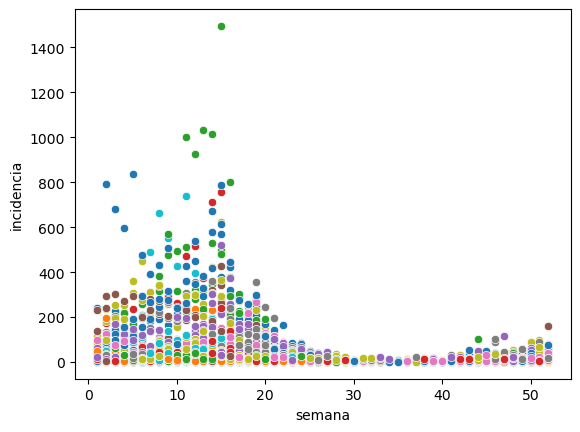

In [20]:
timeSeries = pd.DataFrame()
#listaDistrito = listaDistrito[0:15]
for dis in listaDistrito:
    distrito=df[df['Distrito']==dis]
    distrito.sort_values(['semana'], ascending = True)
    distrito = distrito.reset_index(drop=True)
    distrito = distrito.replace('nan', np.nan).fillna(0.00000000001)
    distrito = distrito.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    timeSeries = timeSeries.append(distrito['incidencia'], ignore_index=True)
    #print(dis)
    ax = sns.scatterplot(y=distrito['incidencia'], x= distrito['semana'])
plt.show()

In [21]:
timeSeries = timeSeries.replace('nan', np.nan).fillna(0.00000000001)
timeSeries = timeSeries.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)

In [22]:
df1

,Distrito,semana,incidencia,ID_distrito
3614,CAACUPE,1,1.950268,24.0
3615,CAPIATA,1,3.386780,4.0
3616,CONCEPCION,1,5.207045,8.0
3617,FERNANDO DE LA MORA,1,7.820188,1.0
3618,HORQUETA,1,47.029315,6.0
...,...,...,...,...
8482,VILLA HAYES,52,13.034128,36.0
8483,VILLETA,52,8.852169,30.0
8484,YAGUARON,52,3.292832,22.0
8485,YPACARAI,52,7.999360,23.0


In [23]:
#from tsfeatures import tsfeatures
#df2 = df1[['ID_distrito', 'incidencia', 'semana']]
#df2 = df2.reset_index(drop=True)
#df2.rename(columns = {'ID_distrito':'unique_id', 'incidencia':'y', 'semana':'ds'}, inplace = True)

In [24]:
lista_aux = timeSeries.values.tolist()
#print(lista_aux)

In [25]:
model = TsFeatures()
aux = timeSeries.loc[[1]].T
aux['time'] = aux.index
aux = aux[['time', 1]]
aux = aux.rename(columns={1: "value"})
aux

,time,value
0,0,7.820188
1,1,7.168505
2,2,4.561776
3,3,3.910094
4,4,8.471870
...,...,...
99,99,19.761964
100,100,16.574550
101,101,21.674412
102,102,19.761964


In [26]:
output_features = model.transform(aux)

In [27]:
aux2 = timeSeries.loc[[1]].squeeze()
#aux2.min()
#aux2.name='TS'
kullback_leibler_score(aux2, 4)
#print(aux2.min()) 

{'score': 2646.2113913939033, 'change_idx': 7}

In [28]:
features = pd.DataFrame()
Mean=[]
Var=[]
aCF1=[]
Trend=[]
Linearity=[]
Curvature=[]
Season=[]
Peak=[]
Entropy=[]
Lumpiness=[]
Lshift=[]
Vchange=[]
Fspots=[]
Cpoints_ts=[]
Klscore=[]
ChangeIdx=[]
num = 0
for dis in listaDistrito:
    print(num)
    distrito_1 = df['Distrito']==dis
    print(dis)
    casos_distrito1 = df[distrito_1]
    casos_distrito1 = casos_distrito1.reset_index(drop=True)
    casos_distrito1 = casos_distrito1['incidencia']
    casos_distrito1 = casos_distrito1.replace('nan', np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace(0, np.nan).fillna(0.00000000001)
    casos_distrito1 = casos_distrito1.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
    if (len(casos_distrito1)>16) :
        #Extracción
        model = TsFeatures()
        #aux = timeSeries.loc[[1]].T
        aux= casos_distrito1.to_frame()
        aux['time'] = aux.index
        aux = aux.rename(columns={"incidencia": "value"})
        aux = aux[['time', 'value']]
        aux
        output_features = model.transform(aux)

        #Features
        mean = output_features['mean']
        var = output_features['var'] 
        ACF1 = output_features['y_acf1']
        trend = output_features['trend_strength']
        linear = output_features['linearity']
        curv = trend_seasonality_spike_strength(casos_distrito1, 4)['curvature']
        season = output_features['seasonality_strength']
        peak = output_features['peak']
        entropy = output_features['entropy']
        lump = output_features['lumpiness']
        lshift = output_features['level_shift_size']
        vchange = rolling_variance_change(casos_distrito1, 4)
        fspots = output_features['flat_spots']
        cpoints_ts = output_features['crossing_points']
        klscore = kullback_leibler_score(aux2, 4)['score']
        changeidx = kullback_leibler_score(aux2, 4)['change_idx']
    else:
        mean = np.nan
        var = np.nan
        ACF1 = np.nan
        trend = np.nan
        linear = np.nan
        curv = np.nan
        season = np.nan
        peak = np.nan
        entropy = np.nan
        lump = np.nan
        lshift = np.nan
        vchange = np.nan
        fspots = np.nan
        cpoints_ts = np.nan
        klscore = np.nan
        changeidx = np.nan

    Mean.append(mean)
    Var.append(var)
    aCF1.append(ACF1)
    Trend.append(trend)
    Linearity.append(linear)
    Curvature.append(curv)
    Season.append(season)
    Peak.append(peak)
    Entropy.append(entropy)
    Lumpiness.append(lump)
    Lshift.append(lshift)
    Vchange.append(vchange)
    Fspots.append(fspots)
    Cpoints_ts.append(cpoints_ts)
    #Cpoints_JV.append(cpoints_jv[0])
    Klscore.append(klscore)
    ChangeIdx.append(changeidx)
    num = num + 1

0
ASUNCION
1
FERNANDO DE LA MORA
2
PEDRO JUAN CABALLERO
3
YPANE
4
CAPIATA
5
CAPITAN BADO
6
HORQUETA
7
BELEN
8
CONCEPCION
9
LAMBARE
10
BELLA VISTA
11
HERNANDARIAS
12
ITAKYRY
13
ITAUGUA
14
CORONEL OVIEDO
15
LOMA PLATA
16
LUQUE
17
MCAL. ESTIGARRIBIA
18
MINGA GUAZU
19
PIRAYU
20
SAN ALBERTO
21
VILLA ELISA
22
YAGUARON
23
YPACARAI
24
CAACUPE
25
EMBOSCADA
26
ITA
27
LIMPIO
28
MARIANO ROQUE ALONSO
29
SAN LORENZO
30
VILLETA
31
GUARAMBARE
32
SAN JOSE DE LOS ARROYOS
33
CAAGUAZU
34
LORETO
35
NUEVA ITALIA
36
VILLA HAYES
37
ACAHAY
38
CARAPEGUA
39
CHORE
40
ENCARNACION
41
FRAM
42
JOSE DOMINGO OCAMPOS
43
PARAGUARI
44
REPATRIACION
45
SAN ANTONIO


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


46
SAN JUAN NEPOMUCENO
47
SANTA ROSA
48
LOMA GRANDE
49
SAN BERNARDINO
50
SAN ESTANISLAO
51
AREGUA
52
ARROYOS Y ESTEROS
53
EUSEBIO AYALA
54
ITACURUBI DE LA CORDILLERA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


55
LA PALOMA
56
MINGA PORA
57
PILAR
58
SALTO DEL GUAIRA
59
SAN PEDRO
60
VILLARRICA
61
ALBERDI
62
CAMBYRETA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


63
NATALIO
64
NUEVA ALBORADA
65
OBLIGADO
66
SAN JUAN BAUTISTA
67
SANTA RITA
68
TOBATI


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


69
MBOCAYATY
70
PIRAPO
71
SAPUCAI


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


72
TACUATI
73
CAAZAPA
74
CURUGUATY
75
TEBICUARY
76
CORONEL MARTINEZ
77
SAN LAZARO
78
ATYRA
79
ALTOS
80
PIRIBEBUY
81
AYOLAS
82
BENJAMIN ACEVAL
83
QUIINDY


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


84
VALENZUELA
85
YGUAZU
86
NUEVA ESPERANZA
87
CAPITAN MIRANDA
88
FUERTE OLIMPO
89
MBARACAYU
90
NANAWA


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


91
NARANJAL
92
KATUETE
93
SAN PEDRO DEL PARANA
94
CARLOS ANTONIO LOPEZ
95
EDELIRA
96
HOHENAU
97
SAN IGNACIO
98
ABAI
99
CAPIIBARY
100
CARAGUATAY
101
CORPUS CHRISTI
102
RAUL ARSENIO OVIEDO
103
TOMAS ROMERO PEREIRA
104
TRINIDAD
105
YEGROS
106
CARAYAO


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features
ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


107
CORONEL BOGADO
108
DR. MOISES BERTONI
109
ESCOBAR
110
GUAYAIBI
111
NUEVA LONDRES
112
SANTA ELENA
113
COLONIA INDEPENDENCIA
114
LA PAZ
115
NUEVA COLOMBIA
116
SAN MIGUEL
117
SANTA ROSA DEL MONDAY
118
VAQUERIA
119
YATAITY
120
ITAPE
121
SANTA ROSA DEL AGUARAY


ERROR:root:Length of time series is shorter than window_size, unable to calculate level shift features


122
FELIX PEREZ CARDOZO
123
GENERAL ARTIGAS
124
LA PASTORA
125
SAN JUAN DEL PARANA
126
SIMON BOLIVAR
127
CAPITAN MEZA
128
SAN JOAQUIN
129
BORJA
130
ITACURUBI DEL ROSARIO
131
JESUS
132
ISLA PUCU
133
VILLA DEL ROSARIO
134
3 DE FEBRERO
135
YUTY
136
YHU
137
TAVAI
138
FILADELFIA
139
MBOCAYATY DEL YHAGUY
140
SAN CARLOS
141
JOSE FASSARDI
142
JUAN DE MENA
143
NUEVA GERMANIA
144
UNION
145
CARMEN DEL PARANA
146
PASO YOBAI
147
TACUARAS
148
YATAITY DEL NORTE
149
25 DE DICIEMBRE
150
SANTA MARIA
151
SANTIAGO
152
MCAL. FRANCISCO SOLANO LOPEZ
153
SAN JOSE OBRERO
154
ITURBE
155
JOSE FALCON
156
NATALICIO TALAVERA
157
ANTEQUERA
158
ITANARA
159
SAN COSME Y DAMIAN
160
TEBICUARYMI
161
ITAPUA POTY
162
MACIEL
163
SAN PATRICIO
164
LAURELES
165
BUENA VISTA
166
LIMA
167
HUMAITA
168
GENERAL DELGADO
169
YATYTAY
170
DR. JUAN MANUEL FRUTOS
171
SAN SALVADOR
172
ALTO VERA
173
AZOTEY
174
SAN RAFAEL DEL PARANA
175
CERRITO
176
YABEBYRY
177
ZANJA PYTA
178
VILLALBIN
179
BAHIA NEGRA
180
TEMBIAPORA
181
TAVAPY
182
LEANDRO OVI

In [29]:
#data_tuples = list(zip(Mean,Var,aCF1, Season, Trend, Linearity, Curvature, Peak, Entropy, Lumpiness, Lshift, Vchange, Fspots, Cpoints_ts, Cpoints_JV, Klscore, ChangeIdx))
#features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Seasonality','Trend', 'Linearity', 'Curvature', 'Peak','Entropy','Lumpiness','Lshift', 'Vchange','Fspots', 'Cpoints_ts', 'Cpoints_JV', 'KlScore', 'ChangeIdx']) 

data_tuples = list(zip(Mean,Var,aCF1,Trend, Linearity, Curvature, Peak, Entropy, Lumpiness, Lshift, Vchange, Fspots, Cpoints_ts, Klscore, ChangeIdx))
features = pd.DataFrame(data_tuples, columns =['Mean', 'Var', 'ACF1','Trend', 'Linearity', 'Curvature', 'Peak','Entropy','Lumpiness','Lshift', 'Vchange','Fspots', 'Cpoints_ts', 'KlScore', 'ChangeIdx']) 
# print the data 
features

,Mean,Var,ACF1,Trend,Linearity,Curvature,Peak,Entropy,Lumpiness,Lshift,Vchange,Fspots,Cpoints_ts,KlScore,ChangeIdx
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65.928702,6667.912864,0.919186,0.920209,0.000005,-5.504601,1.0,0.431543,1.414872e+06,18.741992,6899.490148,2.0,10.0,2646.211391,7.0
2,39.785227,3380.788814,0.909956,0.912973,0.027334,94.049816,2.0,0.456664,4.316017e+06,11.685524,4027.574697,4.0,6.0,2646.211391,7.0
3,81.841557,15492.218046,0.892315,0.919671,0.004914,95.021656,0.0,0.466956,1.575793e+08,26.472764,13844.821967,6.0,16.0,2646.211391,7.0
4,79.770214,20817.368246,0.910265,0.917562,0.020333,229.062011,3.0,0.513312,1.090788e+08,37.707248,42507.111434,2.0,9.0,2646.211391,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
features.insert(0, 'Distrito', y.Distrito.values)
features

NameError: name 'y' is not defined

In [ ]:
features = features.replace('nan', np.nan).fillna(0.00000000001)
features = features.replace(0, np.nan).fillna(0.00000000001)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0.00000000001)
features

In [ ]:
features.to_csv('15Features_2013_Incidencia.csv')

In [ ]:
corr_df = features.corr()
#print("The correlation DataFrame is:")
#print(corr_df, "\n")
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
n= timeSeries.shape[0]
n

# Funciones de Distancias

In [ ]:
import math
from math import sqrt, log, floor
from sklearn.metrics import mean_squared_error
from statistics import mean
from fastdtw import fastdtw
from scipy import stats
from scipy.spatial.distance import pdist

#Euclidean
def euclidean(x, y):
    r=np.linalg.norm(x-y)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Fast Dynamic time warping
def fast_DTW(x, y):
    r, _ = fastdtw(x, y, dist=euclidean)
    if math.isnan(r):
        r=1
    #print(r)
    return r

#Spearman
def scorr(x, y):
    r = stats.spearmanr(x, y)[0]
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

#RMSE
def rmse(x, y):
    r=sqrt(mean_squared_error(x,y))
    if math.isnan(r):
        r=1
    #print(r)
    return r

def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

#Correlation
def corr(x, y):
    r=np.dot(x-mean(x),y-mean(y))/((np.linalg.norm(x-mean(x)))*(np.linalg.norm(y-mean(y))))
    if math.isnan(r):
        r=0
    #print(r)
    return 1 - r

In [ ]:
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']

def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster, or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters

def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c} \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements. Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid, or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)
    
    

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    #print("IC",ic_distances)
    if len(ic_distances[ic_distances.nonzero()])==0:
        min_distance = 0
    else:
        min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))
    
    

    return min_distance / max_diameter

# Distancias

In [ ]:
features = features.replace('nan', np.nan).fillna(0.00000000001)

In [ ]:
features = features.drop('Distrito', axis=1)

In [ ]:
import matplotlib.pyplot as plt
k=7

HAC_EUCLIDEAN=[]
HAC_CORRELATION=[]
HAC_SPEARMAN=[]
HAC_DTW=[]

HAC_EUCLIDEAN_CHZ=[]
HAC_CORRELATION_CHZ=[]
HAC_SPEARMAN_CHZ=[]
HAC_DTW_CHZ=[]

HAC_EUCLIDEAN_DUNN=[]
HAC_CORRELATION_DUNN=[]
HAC_SPEARMAN_DUNN=[]
HAC_DTW_DUNN=[]

#Euclidean
f_euclidean_dist = np.zeros((n,n))
for i in range(0,n):
    #print("i",i)
    for j in range(1,n):
         f_euclidean_dist[i,j] = euclidean(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#Corr
corr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
            corr_dist[i,j] = corr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())

#scorr
f_scorr_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_scorr_dist[i,j] = scorr(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
#DTW
f_dtw_dist = np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        f_dtw_dist[i,j] = fast_DTW(features.iloc[i].values.flatten(), features.iloc[j].values.flatten())
    

#Experimentos HAC
HAC_euc = AgglomerativeClustering(n_clusters=k).fit_predict(f_euclidean_dist)
print("HAC + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, HAC_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, HAC_euc)
print("CHZ: ", chz)
dunn_= dunn(HAC_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_EUCLIDEAN.append(sil)
HAC_EUCLIDEAN_CHZ.append(chz)
HAC_EUCLIDEAN_DUNN.append(dunn_)

HAC_corr = AgglomerativeClustering(n_clusters=k).fit_predict(corr_dist)
print("HAC + corr distance: ")
sil = silhouette_score(corr_dist, HAC_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, HAC_corr)
print("CHZ: ", chz)
dunn_ = dunn(HAC_corr, corr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_CORRELATION.append(sil)
HAC_CORRELATION_CHZ.append(chz)
HAC_CORRELATION_DUNN.append(dunn_)

HAC_scorr = AgglomerativeClustering(n_clusters=k).fit_predict(f_scorr_dist)
print("HAC + scorr distance: ")
sil = silhouette_score(f_scorr_dist, HAC_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, HAC_scorr)
print("CHZ: ", chz)
dunn_ = dunn(HAC_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_SPEARMAN.append(sil)
HAC_SPEARMAN_CHZ.append(chz)
HAC_SPEARMAN_DUNN.append(dunn_)

HAC_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(f_dtw_dist)
print("HAC + dtw distance: ")
sil = silhouette_score(f_dtw_dist, HAC_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, HAC_dtw)
print("CHZ: ", chz)
dunn_ = dunn(HAC_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
HAC_DTW.append(sil)
HAC_DTW_CHZ.append(chz)
HAC_DTW_DUNN.append(dunn_)
print("-----------------------")

In [ ]:
KM_EUCLIDEAN=[]
KM_CORRELATION=[]
KM_SPEARMAN=[]
KM_DTW=[]

KM_EUCLIDEAN_CHZ=[]
KM_CORRELATION_CHZ=[]
KM_SPEARMAN_CHZ=[]
KM_DTW_CHZ=[]

KM_EUCLIDEAN_DUNN=[]
KM_CORRELATION_DUNN=[]
KM_SPEARMAN_DUNN=[]
KM_DTW_DUNN=[]

#Experimentos K-Means
km_euc = KMeans(n_clusters=k).fit_predict(f_euclidean_dist)
print("KM + euclidian distance: ")
sil = silhouette_score(f_euclidean_dist, km_euc)
print("SC: ", sil)
chz = calinski_harabasz_score(f_euclidean_dist, km_euc)
print("CHZ: ", chz)
dunn_ = dunn(km_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
KM_EUCLIDEAN.append(sil)
KM_EUCLIDEAN_CHZ.append(chz)
KM_EUCLIDEAN_DUNN.append(dunn_)

km_corr = KMeans(n_clusters=k).fit_predict(corr_dist)
print("KM + corr distance: ")
sil = silhouette_score(corr_dist, km_corr)
print("SC: ", sil)
chz = calinski_harabasz_score(corr_dist, km_corr)
print("CHZ: ", chz)
dunn_ = dunn(km_corr, corr_dist, 'farthest', 'farthest') 
print("DUNN: ", dunn_)
KM_CORRELATION.append(sil)
KM_CORRELATION_CHZ.append(chz)
KM_CORRELATION_DUNN.append(dunn_)

km_scorr = KMeans(n_clusters=k).fit_predict(f_scorr_dist)
print("KM + scorr distance: ")
sil = silhouette_score(f_scorr_dist, km_scorr)
print("SC: ", sil)
chz = calinski_harabasz_score(f_scorr_dist, km_scorr)
print("CHZ: ", chz)
dunn_ = dunn(km_scorr, f_scorr_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
KM_SPEARMAN.append(sil)
KM_SPEARMAN_CHZ.append(chz)
KM_SPEARMAN_DUNN.append(dunn_)

km_dtw = KMeans(n_clusters=k).fit_predict(f_dtw_dist)
print("KM + dtw distance: ")
sil = silhouette_score(f_dtw_dist, km_dtw)
print("SC: ", sil)
chz = calinski_harabasz_score(f_dtw_dist, km_dtw)
print("CHZ: ", chz)
dunn_ = dunn(km_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
KM_DTW.append(sil)
KM_DTW_CHZ.append(chz)
KM_DTW_DUNN.append(dunn_)

print("-----------------------")

In [ ]:
DBSCAN_EUCLIDEAN=[]
DBSCAN_CORRELATION=[]
DBSCAN_SPEARMAN=[]
DBSCAN_DTW=[]

DBSCAN_EUCLIDEAN_CHZ=[]
DBSCAN_CORRELATION_CHZ=[]
DBSCAN_SPEARMAN_CHZ=[]
DBSCAN_DTW_CHZ=[]

DBSCAN_EUCLIDEAN_DUNN=[]
DBSCAN_CORRELATION_DUNN=[]
DBSCAN_SPEARMAN_DUNN=[]
DBSCAN_DTW_DUNN=[]

#CON EUCLIDEAN
DB_euc = DBSCAN(eps=0.5, min_samples=5).fit_predict(f_euclidean_dist)
print("DBSCAN + euclidian distance: ")
sil =  silhouette_score(f_euclidean_dist, DB_euc)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_euclidean_dist, DB_euc) 
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_euc, f_euclidean_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
DBSCAN_EUCLIDEAN.append(sil)
DBSCAN_EUCLIDEAN_CHZ.append(CHZ_)
DBSCAN_EUCLIDEAN_DUNN.append(dunn_)

#CON CORRELATION
DB_corr = DBSCAN(eps=0.5, min_samples=5).fit_predict(corr_dist)
print("DBSCAN + corr distance: ")
print("SC: ",silhouette_score(corr_dist, DB_corr))
print("CHZ: ",calinski_harabasz_score(corr_dist, DB_corr))
print("DUNN: ",dunn(DB_corr, corr_dist, 'farthest', 'farthest'))
DBSCAN_CORRELATION.append(sil)
DBSCAN_CORRELATION_CHZ.append(CHZ_)
DBSCAN_CORRELATION_DUNN.append(dunn_)

#CON SPEARMAN
DB_scorr = DBSCAN(eps=0.5, min_samples=5).fit_predict(f_scorr_dist)
print("DBSCAN + scorr distance: ")
print("SC: ",silhouette_score(f_scorr_dist, DB_scorr))
print("CHZ: ",calinski_harabasz_score(f_scorr_dist, DB_scorr))
print("DUNN: ",dunn(DB_scorr, f_scorr_dist, 'farthest', 'farthest'))
print("-----------------------")
DBSCAN_SPEARMAN.append(sil)
DBSCAN_SPEARMAN_CHZ.append(CHZ_)
DBSCAN_SPEARMAN_DUNN.append(dunn_)

#CON D TIME WARPING
DB_dtw = DBSCAN(eps=0.5, min_samples=5).fit_predict(f_dtw_dist)
print("DBSCAN + dtw distance: ")
sil = silhouette_score(f_dtw_dist, DB_dtw)
print("SC: ", sil)
CHZ_ = calinski_harabasz_score(f_dtw_dist, DB_dtw)
print("CHZ: ", CHZ_)
dunn_ = dunn(DB_dtw, f_dtw_dist, 'farthest', 'farthest')
print("DUNN: ", dunn_)
DBSCAN_DTW.append(sil)
DBSCAN_DTW_CHZ.append(CHZ_)
DBSCAN_DTW_DUNN.append(dunn_)

In [ ]:
sil_scores = pd.DataFrame()
sil_scores['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN)
sil_scores['CORRELATION-HAC'] = np.array(HAC_CORRELATION)
sil_scores['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN)
sil_scores['DTW-HAC'] = np.array(HAC_DTW)
sil_scores['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN)
sil_scores['CORRELATION-KM'] = np.array(KM_CORRELATION)
sil_scores['SPEARMAN-KM'] = np.array(KM_SPEARMAN)
sil_scores['DTW-KM'] = np.array(KM_DTW)
sil_scores['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN)
sil_scores['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION)
sil_scores['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN)
sil_scores['DTW-DB'] = np.array(DBSCAN_DTW)

calinski = pd.DataFrame()
calinski['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN_CHZ)
calinski['CORRELATION-HAC'] = np.array(HAC_CORRELATION_CHZ)
calinski['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN_CHZ)
calinski['DTW-HAC'] = np.array(HAC_DTW_CHZ)
calinski['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN_CHZ)
calinski['CORRELATION-KM'] = np.array(KM_CORRELATION_CHZ)
calinski['SPEARMAN-KM'] = np.array(KM_SPEARMAN_CHZ)
calinski['DTW-KM'] = np.array(KM_DTW_CHZ)
calinski['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN_CHZ)
calinski['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION_CHZ)
calinski['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN_CHZ)
calinski['DTW-DB'] = np.array(DBSCAN_DTW_CHZ)

dunn_df = pd.DataFrame()
dunn_df['EUCLIDEAN-HAC'] = np.array(HAC_EUCLIDEAN_DUNN)
dunn_df['CORRELATION-HAC'] = np.array(HAC_CORRELATION_DUNN)
dunn_df['SPEARMAN-HAC'] = np.array(HAC_SPEARMAN_DUNN)
dunn_df['DTW-HAC'] = np.array(HAC_DTW_DUNN)
dunn_df['EUCLIDEAN-KM'] = np.array(KM_EUCLIDEAN_DUNN)
dunn_df['CORRELATION-KM'] = np.array(KM_CORRELATION_DUNN)
dunn_df['SPEARMAN-KM'] = np.array(KM_SPEARMAN_DUNN)
dunn_df['DTW-KM'] = np.array(KM_DTW_DUNN)
dunn_df['EUCLIDEAN-DB'] = np.array(DBSCAN_EUCLIDEAN_DUNN)
dunn_df['CORRELATION-DB'] = np.array(DBSCAN_CORRELATION_DUNN)
dunn_df['SPEARMAN-DB'] = np.array(DBSCAN_SPEARMAN_DUNN)
dunn_df['DTW-DB'] = np.array(DBSCAN_DTW_DUNN)

In [ ]:
sil_scores.to_csv('SilhoutteScore_15FeaturesPY_2012_2013.csv')
calinski.to_csv('CHZScore_15FeaturesPY2012_2013.csv')
dunn_df.to_csv('DUNN_15FeaturesPY2012_2013.csv')

# GRÁFICOS

In [ ]:
features

In [ ]:
distritos = features.Distrito.values

In [ ]:
features = features.drop('Distrito', axis=1)

In [ ]:
features

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(features)
df_embedded = pd.DataFrame(X_embedded)
df_embedded.insert(0, "Cluster", HAC_euc, allow_duplicates=True)
df_embedded

In [ ]:
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#8A2BE2', '#3D9140', '#FFD700', '#FF1493']
df_embedded['Cluster'] = df_embedded.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[6], 6:colors[5]})
l = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
#plotting the results:
df_embedded.plot.scatter(1, 0, c="Cluster")


In [ ]:
X_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(features)
df_embedded3 = pd.DataFrame(X_embedded3)
df_embedded3.insert(0, "Cluster", HAC_euc, allow_duplicates=True)

df_embedded3

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
seg_std=scaler.fit_transform(features) 
pca = PCA()
pca.fit(seg_std)
plt.figure(figsize = (10,8))
plt.plot(range(1,17), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.xlabel('Numer of components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
model.fit(features)

plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
colors = ['navy']*6+['darkorange']*6+['k']*6+['red']*6+['yellow']*6+['cyan']*6
Names = ['Class 0']*6+['Class 1']*6+['Class 2']*6+['Class 3']*6+['Class 4']*6+['Class 5']*6

y=model.predict(features)
x = list(range(n))

for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,features[k],'.',color=colors[j-1])
    plt.ylabel('Cases',fontsize=20)
    plt.xlabel('Week',fontsize=20)
    plt.title('City=%s, Class = %s'%(listaDistrito[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),data_array.max())

In [ ]:
model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
model.fit(features)
model.labels_.shape

In [ ]:
timeSeries

In [ ]:
timeSeries.loc[1,:].values

In [ ]:
timeSeries.loc[1,:].values

In [ ]:
plt.figure(figsize=(12, 10))
for j in list(range(7)):
    #print("J es: ", j)
    plt.subplot(4,2,j+1)
    #plt.title('Class = %s'%(),fontsize=20)
    for i in list(range(len(timeSeries))):
        #print("I es: ", i)
        if(model.labels_[i]==j):
            #print(timeSeries.loc[i,:].values)
            plt.plot(list(range(len(timeSeries.loc[i,:].values))), timeSeries.loc[i,:].values,'.')